<a href="https://colab.research.google.com/github/NEC0S/AIC_Assignment/blob/main/Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import os
import cv2
import imghdr
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pycocotools.coco import COCO
import os
import requests
import numpy as np
import random
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

## **Import Data**

In [2]:
!pip install CocoDataset==0.1.2

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2024-05-18 13:20:28--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.30.209, 3.5.25.85, 3.5.24.206, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.30.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  61.6MB/s    in 7.9s    

2024-05-18 13:20:36 (30.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [4]:
# Function to download images of a specific class from COCO dataset
def download_images(class_name, images_count, annotations_path, download_path):
    # Initialize COCO api
    coco = COCO(annotations_path)

    # Get category ID for the given class name
    cat_ids = coco.getCatIds(catNms=[class_name])
    img_ids = coco.getImgIds(catIds=cat_ids)

    # Select random images
    random_img_ids = random.sample(img_ids, min(images_count, len(img_ids)))

    # Create download folder if not exists
    os.makedirs(download_path, exist_ok=True)

    # Download images
    for img_id in random_img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        img_url = img_info['coco_url']
        img_path = os.path.join(download_path, img_name)
        with open(img_path, 'wb') as img_file:
            img_file.write(requests.get(img_url).content)

# Function to split dataset into train and test
def split_dataset(dataset_path, train_path, test_path, split_ratio=0.2):
    # Create train and test folders if not exists
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Get list of images
    images = os.listdir(dataset_path)
    random.shuffle(images)

    # Split images into train and test
    split_index = int(len(images) * split_ratio)
    train_images = images[split_index:]
    test_images = images[:split_index]

    # Move images to train folder
    for img in train_images:
        img_class = img.split("_")[0]  # Extract class name from image filename
        class_train_path = os.path.join(train_path, img_class)
        os.makedirs(class_train_path, exist_ok=True)
        shutil.move(os.path.join(dataset_path, img), os.path.join(class_train_path, img))

    # Move images to test folder
    for img in test_images:
        shutil.move(os.path.join(dataset_path, img), os.path.join(test_path, img))

# Parameters
class_list = [
    'person', 'car', 'bicycle', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'fire hydrant']

images_count = 50      # Count of images per class
annotations_path = '/content/annotations/instances_train2017.json'  # Path of COCO dataset annotations
download_path = '/content/coco_images'  # Path to download images
# Modified train and test paths to include class subdirectories
train_path = '/content/train'
test_path = '/content/test'

# Loop through each class
for class_name in class_list:
    download_images(class_name, images_count, annotations_path, download_path)
    # Modified train and test paths to include class subdirectories
    split_dataset(download_path, os.path.join(train_path, class_name), os.path.join(test_path, class_name))


loading annotations into memory...
Done (t=58.83s)
creating index...
index created!
loading annotations into memory...
Done (t=31.70s)
creating index...
index created!
loading annotations into memory...
Done (t=31.08s)
creating index...
index created!
loading annotations into memory...
Done (t=22.45s)
creating index...
index created!
loading annotations into memory...
Done (t=28.24s)
creating index...
index created!
loading annotations into memory...
Done (t=28.80s)
creating index...
index created!
loading annotations into memory...
Done (t=26.01s)
creating index...
index created!
loading annotations into memory...
Done (t=21.92s)
creating index...
index created!
loading annotations into memory...
Done (t=31.05s)
creating index...
index created!
loading annotations into memory...
Done (t=30.12s)
creating index...
index created!


## **Data Analysis**

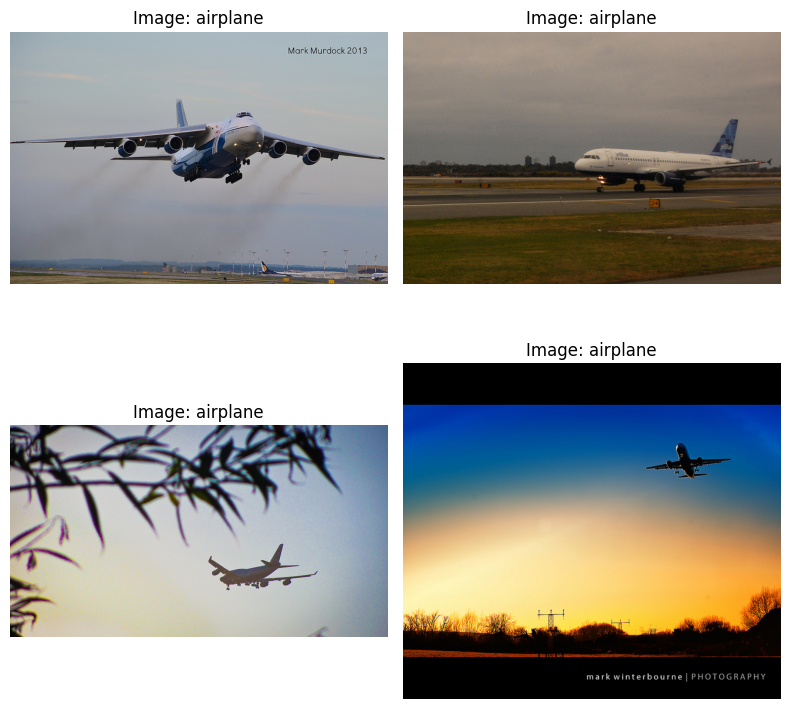

In [5]:
def plot_images_from_directory(directory_path, class_animal, num_images=4):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file,image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_animal}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

# Placeholder for the directory path
directory_path = '/content/train/airplane'  # Replace with your directory path
plot_images_from_directory(directory_path, class_animal = 'airplane')

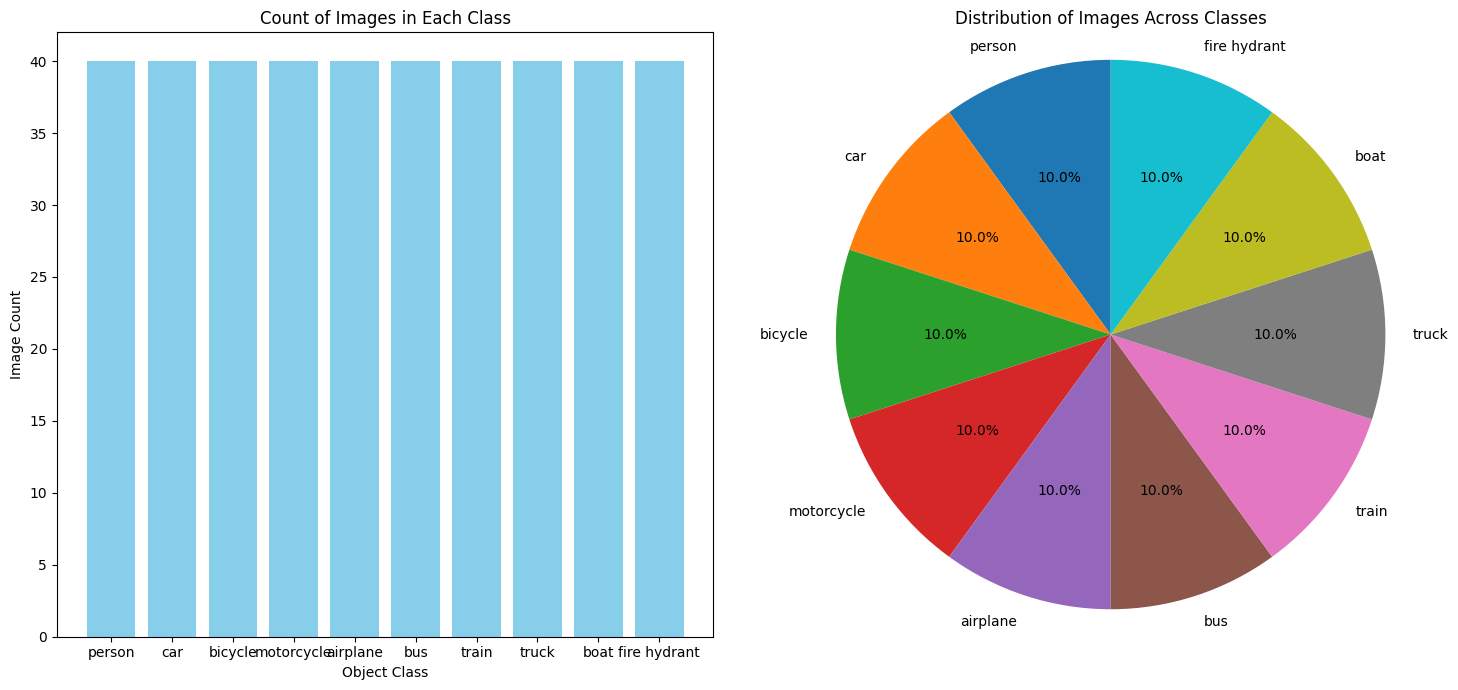

In [6]:
# Define the class list and corresponding counts
class_list = [
    'person', 'car', 'bicycle', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'fire hydrant']

class_counts = []

for class_animal in class_list:
    class_directory_path = os.path.join('/content/train', class_animal)
    class_images = os.listdir(class_directory_path)
    class_count = len(class_images)
    class_counts.append(class_count)

# Setting up a figure and axes for two subplots: one for the bar chart, one for the pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Bar chart on the first subplot
ax[0].bar(class_list, class_counts, color='skyblue')
ax[0].set_xlabel('Object Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Count of Images in Each Class')

# Pie chart on the second subplot
ax[1].pie(class_counts, labels=class_list, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Distribution of Images Across Classes')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the layout so that both subplots fit nicely
plt.tight_layout()
plt.show()


In [7]:

# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check if the file extension is in the allowed list
            file_ext = file.split('.')[-1].lower()
            if file_ext not in image_exts:
                print(f'Removing file: {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)


## **Model Building**

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# Set path to the dataset
base_dir = '/content/train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [9]:
# Using 20% of data for validation
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resizing images to 150x150
    batch_size=20,
    class_mode='categorical',  # For multi-class classification
    subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    subset='validation')  # Set as validation data


Found 320 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


In [10]:
# Ensure the generators are able to locate the images
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)

# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)


Number of training samples: 320
Number of validation samples: 80
Training class labels: {'airplane': 0, 'bicycle': 1, 'boat': 2, 'bus': 3, 'car': 4, 'fire hydrant': 5, 'motorcycle': 6, 'person': 7, 'train': 8, 'truck': 9}
Validation class labels: {'airplane': 0, 'bicycle': 1, 'boat': 2, 'bus': 3, 'car': 4, 'fire hydrant': 5, 'motorcycle': 6, 'person': 7, 'train': 8, 'truck': 9}


## **Models**

In [11]:
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt

# Create the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-2),
              metrics=['acc'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Epoch 1/20
16/16 [==============================] - 22s 1s/step - loss: 2.4359 - acc: 0.0781 - val_loss: 2.3006 - val_acc: 0.0625
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 2.3064 - acc: 0.1000 - val_loss: 2.3012 - val_acc: 0.1250
Epoch 3/20
16/16 [==============================] - 25s 2s/step - loss: 2.3678 - acc: 0.1219 - val_loss: 2.2835 - val_acc: 0.1500
Epoch 4/20
16/16 [==============================] - 34s 2s/step - loss: 2.2439 - acc: 0.1656 - val_loss: 2.2680 - val_acc: 0.1500
Epoch 5/20
16/16 [==============================] - 29s 2s/step - loss: 2.2070 - acc: 0.1688 - val_loss: 2.2945 - val_acc: 0.1875
Epoch 6/20
16/16 [==============================] - 29s 2s/step - loss: 2.0973 - acc: 0.2469 - val_loss: 2.2357 - val_acc: 0.1375
Epoch 7/20
16/16 [==============================] - 29s 2s/step - loss: 2.0789 - acc: 0.2719 - val_loss: 2.4008 - val_acc: 0.1250
Epoch 8/20
16/16 [==============================] - 24s 2s/step - loss: 1.9834 - acc: 0.30

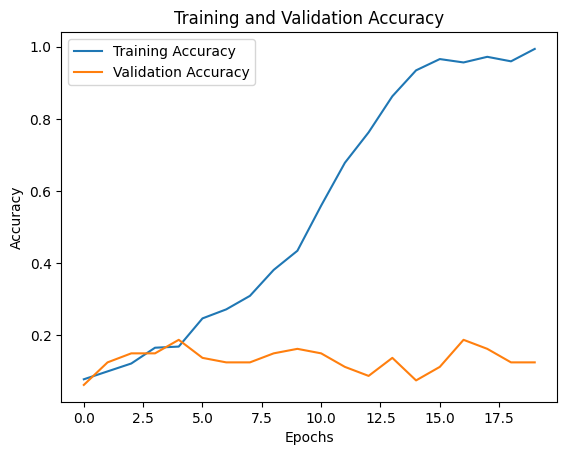

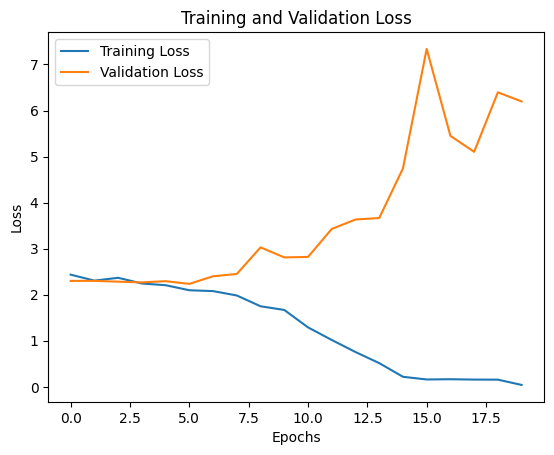

In [12]:
# Calculate the number of training and validation steps per epoch
# Total number of training and validation samples
total_train_samples = train_generator.samples
total_validation_samples = validation_generator.samples

# Batch size
batch_size = 20

# Calculate steps per epoch and validation steps
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_validation_samples // batch_size

# Train the model using calculated steps_per_epoch and validation_steps
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Visualize the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    layers.Dense(10, activation='softmax')  # Softmax activation for multi-class classification
])

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-2),
              metrics=['acc'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                      

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                      

Epoch 1/20
16/16 [==============================] - 33s 2s/step - loss: 8.9614 - acc: 0.1219 - val_loss: 2.7031 - val_acc: 0.0750
Epoch 2/20
16/16 [==============================] - 38s 2s/step - loss: 4.6287 - acc: 0.2062 - val_loss: 4.0714 - val_acc: 0.1000
Epoch 3/20
16/16 [==============================] - 30s 2s/step - loss: 3.1953 - acc: 0.2844 - val_loss: 8.1466 - val_acc: 0.1125
Epoch 4/20
16/16 [==============================] - 41s 3s/step - loss: 2.6094 - acc: 0.4062 - val_loss: 6.5159 - val_acc: 0.1125
Epoch 5/20
16/16 [==============================] - 41s 3s/step - loss: 1.8704 - acc: 0.5219 - val_loss: 6.5831 - val_acc: 0.0500
Epoch 6/20
16/16 [==============================] - 37s 2s/step - loss: 1.8987 - acc: 0.4844 - val_loss: 15.3388 - val_acc: 0.1000
Epoch 7/20
16/16 [==============================] - 39s 3s/step - loss: 1.3891 - acc: 0.5875 - val_loss: 13.6689 - val_acc: 0.1125
Epoch 8/20
16/16 [==============================] - 50s 3s/step - loss: 0.7721 - acc: 0.

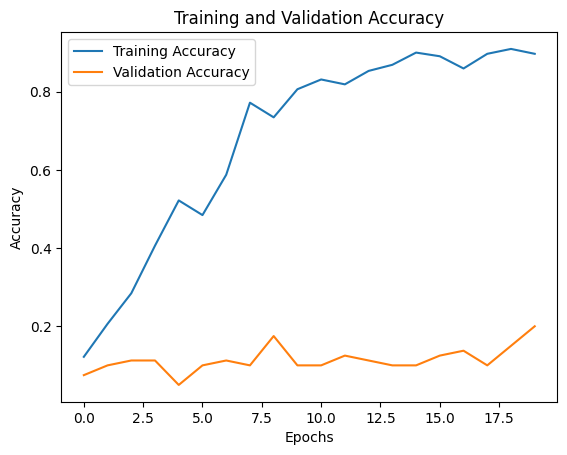

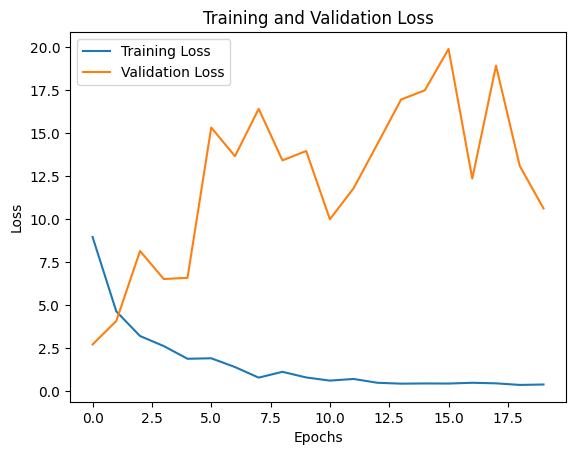

In [14]:
# Calculate the number of training and validation steps per epoch
# Total number of training and validation samples
total_train_samples = train_generator.samples
total_validation_samples = validation_generator.samples

# Batch size
batch_size = 20

# Calculate steps per epoch and validation steps
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_validation_samples // batch_size

# Train the model using calculated steps_per_epoch and validation_steps
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Visualize the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## **Transfer Learning**

In [15]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet',
                   include_top=False,  # Exclude the densely connected classifier on top
                   input_shape=(150, 150, 3))  # Input shape corresponding to our dataset

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,  # Add the VGG16 convolutional base
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Display the model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 18914634 (72.15 MB)
Trainable params: 4199946 (16.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Epoch 1/20
16/16 [==============================] - 165s 10s/step - loss: 4.5033 - acc: 0.1719 - val_loss: 2.3026 - val_acc: 0.1875
Epoch 2/20
16/16 [==============================] - 157s 10s/step - loss: 1.7679 - acc: 0.4094 - val_loss: 2.5331 - val_acc: 0.2750
Epoch 3/20
16/16 [==============================] - 164s 10s/step - loss: 1.3178 - acc: 0.5437 - val_loss: 3.2840 - val_acc: 0.2125
Epoch 4/20
16/16 [==============================] - 156s 10s/step - loss: 0.7247 - acc: 0.7937 - val_loss: 3.1192 - val_acc: 0.2375
Epoch 5/20
16/16 [==============================] - 164s 10s/step - loss: 0.6203 - acc: 0.8281 - val_loss: 2.9388 - val_acc: 0.2125
Epoch 6/20
16/16 [==============================] - 165s 10s/step - loss: 0.2921 - acc: 0.9281 - val_loss: 2.7688 - val_acc: 0.3375
Epoch 7/20
16/16 [==============================] - 164s 10s/step - loss: 0.3524 - acc: 0.9250 - val_loss: 3.1520 - val_acc: 0.3000
Epoch 8/20
16/16 [==============================] - 169s 11s/step - loss: 0.

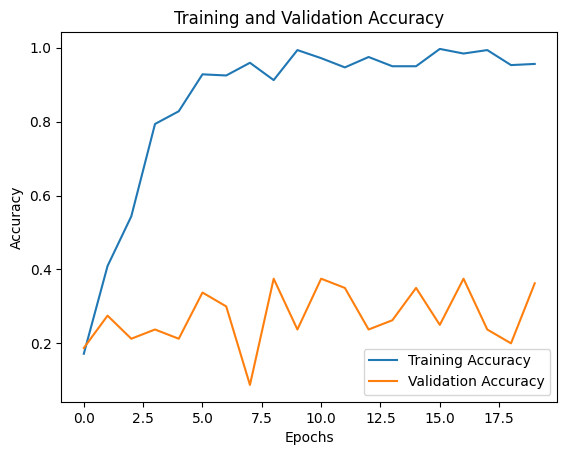

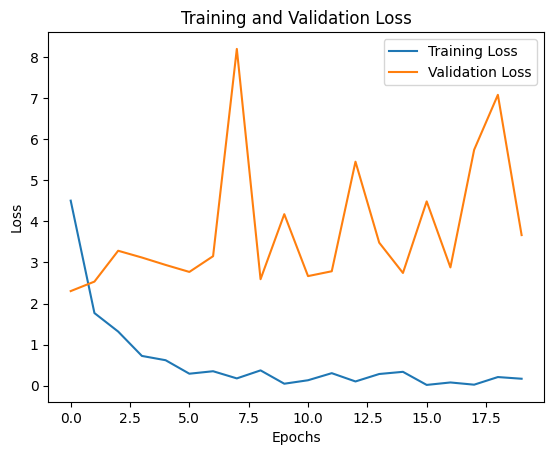

In [16]:
# Calculate the number of training and validation steps per epoch
# Total number of training and validation samples
total_train_samples = train_generator.samples
total_validation_samples = validation_generator.samples

# Batch size
batch_size = 20

# Calculate steps per epoch and validation steps
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_validation_samples // batch_size

# Train the model using calculated steps_per_epoch and validation_steps
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Visualize the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [17]:
from keras.applications import ResNet50
from keras import models
from keras import layers
from keras import optimizers

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet',
                      include_top=False,  # Exclude the densely connected classifier on top
                      input_shape=(150, 150, 3))  # Input shape corresponding to our dataset

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,  # Add the ResNet50 convolutional base
    layers.GlobalAveragePooling2D(),  # Convert features to vectors
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Display the model summary
model.summary()


94765736/94765736 [==============================] - 1s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/20
16/16 [==============================] - 55s 3s/step - loss: 2.5199 - acc: 0.0656 - val_loss: 2.3666 - val_acc: 0.1000
Epoch 2/20
16/16 [==============================] - 55s 3s/step - loss: 2.3657 - acc: 0.0750 - val_loss: 2.3237 - val_acc: 0.1000
Epoch 3/20
16/16 [==============================] - 46s 3s/step - loss: 2.3418 - acc: 0.1000 - val_loss: 2.3945 - val_acc: 0.1125
Epoch 4/20
16/16 [==============================] - 55s 3s/step - loss: 2.3319 - acc: 0.1250 - val_loss: 2.3600 - val_acc: 0.1500
Epoch 5/20
16/16 [==============================] - 52s 3s/step - loss: 2.3229 - acc: 0.1312 - val_loss: 2.3143 - val_acc: 0.1125
Epoch 6/20
16/16 [==============================] - 56s 4s/step - loss: 2.2888 - acc: 0.1437 - val_loss: 2.3852 - val_acc: 0.1125
Epoch 7/20
16/16 [==============================] - 54s 3s/step - loss: 2.2621 - acc: 0.1500 - val_loss: 2.2901 - val_acc: 0.1125
Epoch 8/20
16/16 [==============================] - 56s 4s/step - loss: 2.2647 - acc: 0.13

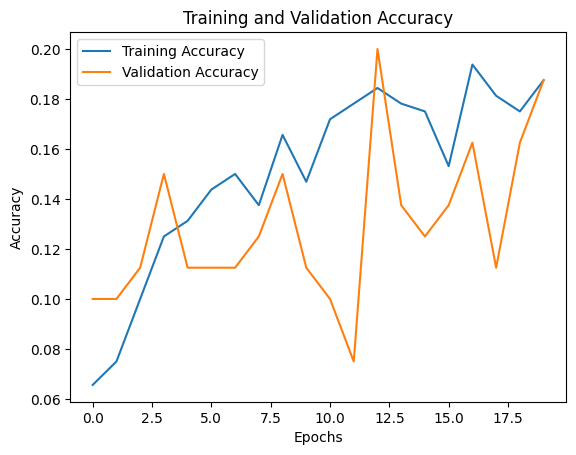

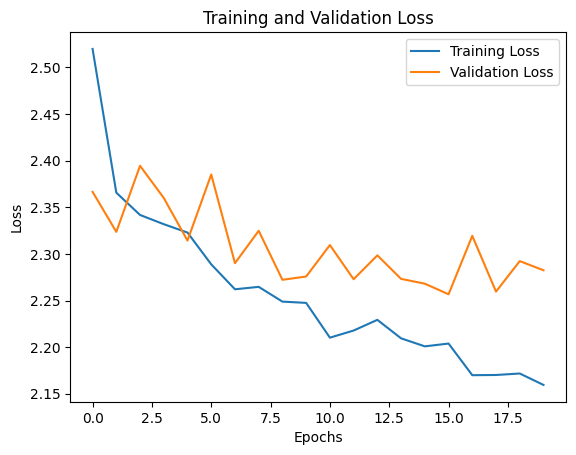

In [18]:
# Calculate the number of training and validation steps per epoch
# Total number of training and validation samples
total_train_samples = train_generator.samples
total_validation_samples = validation_generator.samples

# Batch size
batch_size = 20

# Calculate steps per epoch and validation steps
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_validation_samples // batch_size

# Train the model using calculated steps_per_epoch and validation_steps
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps)

# Visualize the training and validation accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### **This was a good model Less overfit**

## **Model Evaulation**

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

test_dir = '/content/test'  # Path to your test directory

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Should match the input size of your network
    batch_size=20,  # Can adjust based on your memory constraints
    class_mode='categorical',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=False)  # No need to shuffle test data

Found 100 images belonging to 10 classes.


In [20]:
np.ceil(test_generator.samples/test_generator.batch_size)

5.0

In [21]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


5/5 [==============================] - 14s 3s/step - loss: 2.2483 - acc: 0.2100
Test Loss: 2.248304843902588
Test Accuracy: 0.20999999344348907


In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.metrics import precision_recall_curve

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert one-hot encoded labels to numerical labels
y_true = test_generator.classes

# Convert predicted probabilities to numerical labels
y_pred = np.argmax(predictions, axis=1)

# Calculate precision, recall, and average precision
# Compute precision-recall pairs for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
    average_precision[i] = average_precision_score(y_true == i, predictions[:, i])

# Compute the average precision across all classes
mean_average_precision = np.mean(list(average_precision.values()))

print("Mean Average Precision (mAP):", mean_average_precision)
print("Precision:", precision)
print("Recall:", recall)
print("mAP (Mean Average Precision):", average_precision)


5/5 [==============================] - 16s 3s/step
Mean Average Precision (mAP): 0.2198588764107346
Precision: {0: array([0.1       , 0.1010101 , 0.10204082, 0.10309278, 0.10416667,
       0.10526316, 0.10638298, 0.10752688, 0.10869565, 0.10989011,
       0.11111111, 0.11235955, 0.11363636, 0.11494253, 0.11627907,
       0.11764706, 0.11904762, 0.12048193, 0.12195122, 0.12345679,
       0.125     , 0.12658228, 0.12820513, 0.12987013, 0.13157895,
       0.13333333, 0.13513514, 0.1369863 , 0.13888889, 0.14084507,
       0.14285714, 0.14492754, 0.14705882, 0.14925373, 0.15151515,
       0.15384615, 0.15625   , 0.15873016, 0.16129032, 0.16393443,
       0.16666667, 0.16949153, 0.17241379, 0.1754386 , 0.17857143,
       0.18181818, 0.18518519, 0.18867925, 0.19230769, 0.19607843,
       0.2       , 0.20408163, 0.20833333, 0.21276596, 0.2173913 ,
       0.22222222, 0.22727273, 0.23255814, 0.23809524, 0.2195122 ,
       0.225     , 0.23076923, 0.23684211, 0.24324324, 0.25      ,
       0.25714

In [26]:
np.ceil(test_generator.samples/test_generator.batch_size)

5.0

In [27]:
# Reset the test generator
test_generator.reset()

# Get the true labels
true_classes = test_generator.classes

# Predict probabilities for all classes
probabilities = model.predict(test_generator,
                              steps=np.ceil(test_generator.samples/test_generator.batch_size))

# Get the predicted classes by selecting the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Class labels can be obtained from the class indices of the test generator
class_labels = list(test_generator.class_indices.keys())

# Print the first few predicted classes and corresponding probabilities
for i in range(5):  # Print the first 5 samples
    print("Sample", i+1)
    print("Predicted class:", class_labels[predicted_classes[i]])
    print("Probabilities:", probabilities[i])
    print()  # Add a newline for better readability


5/5 [==============================] - 14s 3s/step
Sample 1
Predicted class: airplane
Probabilities: [0.21344224 0.0276388  0.15961912 0.07764994 0.10546128 0.09664301
 0.06995032 0.03908284 0.13592559 0.07458688]

Sample 2
Predicted class: airplane
Probabilities: [0.270803   0.02058982 0.18380746 0.05949816 0.10905976 0.09213698
 0.05122409 0.03218837 0.11836302 0.06232936]

Sample 3
Predicted class: airplane
Probabilities: [0.17718446 0.02812941 0.16475837 0.07804227 0.12060589 0.11637474
 0.07066903 0.03296949 0.13639192 0.07487439]

Sample 4
Predicted class: airplane
Probabilities: [0.2264464  0.02498688 0.16550007 0.064932   0.11804921 0.10175434
 0.06554909 0.03367257 0.12775676 0.07135266]

Sample 5
Predicted class: airplane
Probabilities: [0.26609105 0.02157575 0.17218052 0.06120054 0.10667706 0.09344357
 0.05647181 0.03333817 0.12565699 0.06336459]



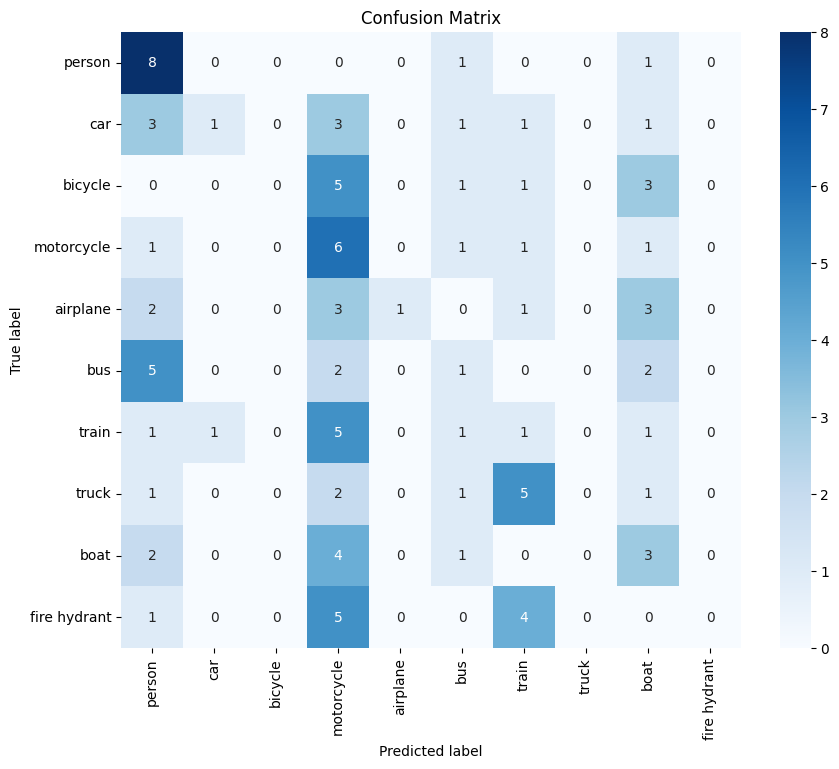

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming true_classes and predicted_classes are defined

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Define class labels
class_labels = [
    'person', 'car', 'bicycle', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'fire hydrant']

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### **Provide a detailed discussion on the performance of your model with examples of detected objects in test images.**

I am going to take one image from the test dataset and do prediction in it.

1/1 [==============================] - 0s 367ms/step


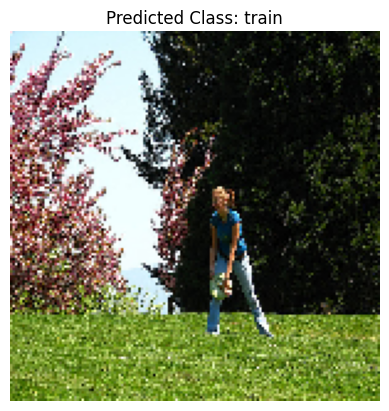

In [33]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

def make_prediction(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Make prediction
    prediction = model.predict(img_array)[0]

    # Get the predicted class label
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/test/person/000000235479.jpg'  # Replace with the path to your image
make_prediction(image_path)


# Reasons for Poor Prediction in CNN Model


1. **Insufficient Data**: As dataset count is Low

2. **Overfitting**: Model is highly Overfit, I have not tried Hypermarameter tuning it may decerease to some extend not again dataset is so low.

3. **Poor Data Quality**: If we data set it not so good there are many objects(Noisy) in a single image make mode difficult to pridict.

There can be many other reason also as exampel:
**Inappropriate Architecture**,
**Incorrect Hyperparameters**,
**Limited Computational Resources**


# **Discuss any challenges faced during the model implementation and training phases.**



## **Challenges Faced during Model Implementation and Training**


  **Limited Computational Resources**
  
   **Data Scarcity**
       
  **Overfitting**
        

  **Hyperparameter Tuning**
        
  **Transfer Learning and Model Selection**
       


# **Suggest potential improvements or alternative approaches that could be explored further**

#Improvements
Use better and Advanced Architectures and Techniques:

Ensemble Learning like  bagging, boosting can help

many more
